In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns

Exploring the dataset

1.   First load the data set
2.   Identify each column
3.   Remove uncessary columns

In [2]:
system_logs_gross_data = pd.read_csv('/kaggle/input/component-metrics/d.2018.0050524986/data/data_1.csv')
system_logs_gross_data.columns

Index(['vector', 'malware', 'total_pro', 'cpu_sys', 'cpu_user', 'max_pid',
       'memory', 'rx_bytes', 'rx_packets', 'total_pro.1', 'sample_id',
       'tx_bytes', 'tx_packets', 'swap', 'test_set'],
      dtype='object')

1. vector: time in seconds since start of file execution (numeric)
2. malware: class label 0=benign, 1=malicious (categorical)
3. total_pro: total number of processes running (numeric)
4. cpu_sys: percentage of cpu being used to run programs in system kernel (numeric)
5. cpu_user: percentage of cpu being used to run programs in user space (numeric)
6. max_pid: maximum process id held by a process (numeric)
7. memory: bytes currently being used in memory (numeric)
8. rx_bytes: number of bytes being received (numeric)
9. rx_packets: number of packets being received (numeric)
10. total_pro.1: duplicate of total_pro
11. sample_id: an identifier value for the samples (categorical)
12. tx_bytes: number of bytes being sent (numeric)
13. tx_packets: number of packets being sent (numeric)
14. swap: bytes currently being used in swap memory (numeric)
15. test_set: True=sample belongs to test set, False=sample belongs to training set

test_set is unncessary during the data exploration phase
notes in columns:
total_pro.1 is unknown, see if we can figure out if it's duplicate
check if there is anything interesting between cpu_sys vs user, if not remove

In [3]:
system_logs_subset = system_logs_gross_data[['vector', 'malware', 'total_pro', 'cpu_sys', 'cpu_user', 'max_pid',
       'memory', 'rx_bytes', 'rx_packets', 'tx_bytes', 'tx_packets', 'swap']]
system_logs_subset

,vector,malware,total_pro,cpu_sys,cpu_user,max_pid,memory,rx_bytes,rx_packets,tx_bytes,tx_packets,swap
0,0,0,49.0,0.204887,0.088346,3036.0,650321920.0,3317908.0,2726.0,713908.0,1066.0,693821440.0
1,1,0,44.0,0.044256,0.058380,3036.0,653524992.0,3319254.0,2736.0,715583.0,1079.0,698855424.0
2,2,0,44.0,0.015052,0.000000,3036.0,651018240.0,3320141.0,2744.0,716557.0,1087.0,698916864.0
3,3,0,44.0,0.000000,0.969000,3036.0,651747328.0,3321028.0,2752.0,717516.0,1095.0,697835520.0
4,4,0,44.0,0.000000,0.230542,3036.0,640745472.0,3321813.0,2758.0,717939.0,1099.0,688144384.0
...,...,...,...,...,...,...,...,...,...,...,...,...
343450,269,1,45.0,0.000000,0.000000,3028.0,597200896.0,1917391.0,3393.0,339851.0,2813.0,769937408.0
343451,270,1,45.0,0.000000,0.000000,3028.0,595890176.0,1918121.0,3399.0,340721.0,2820.0,770043904.0
343452,271,1,45.0,0.000000,0.000000,3028.0,595890176.0,1919008.0,3407.0,341665.0,2828.0,770265088.0
343453,272,1,45.0,0.000000,0.000000,3028.0,593780736.0,1919895.0,3415.0,342609.0,2836.0,770260992.0


First I want an overview of the data, so I will use the .describe() funcation

In [4]:
system_logs_subset.describe()

,vector,malware,total_pro,cpu_sys,cpu_user,max_pid,memory,rx_bytes,rx_packets,tx_bytes,tx_packets,swap
count,343455.000000,343455.000000,343455.000000,343455.000000,343455.000000,343455.000000,3.434550e+05,3.434550e+05,343455.000000,3.434550e+05,343455.000000,3.434550e+05
mean,144.139136,0.493541,43.342496,0.023828,0.043450,2972.753077,6.491333e+08,6.300753e+06,7572.924770,4.279706e+06,4859.498485,7.584479e+08
std,83.605935,0.499959,2.198512,0.073546,0.128023,100.585536,5.735447e+07,1.356140e+07,14927.466622,2.047440e+07,15462.344472,8.235241e+07
min,0.000000,0.000000,40.000000,0.000000,0.000000,2440.000000,5.398528e+08,1.590514e+06,1169.000000,4.434500e+04,357.000000,6.547497e+08
25%,72.000000,0.000000,42.000000,0.000000,0.000000,2900.000000,6.137078e+08,1.863800e+06,2398.000000,2.079745e+05,1357.000000,7.420150e+08
50%,144.000000,0.000000,43.000000,0.000000,0.000000,3012.000000,6.369649e+08,2.104074e+06,3216.000000,3.291120e+05,2184.000000,7.529144e+08
75%,216.000000,1.000000,45.000000,0.015519,0.000000,3044.000000,6.785966e+08,3.510714e+06,5035.000000,1.110854e+06,2922.000000,7.670497e+08
max,305.000000,1.000000,62.000000,0.797000,1.000000,4092.000000,1.544548e+09,8.182960e+07,215263.000000,3.545020e+08,268326.000000,2.026312e+09


Values seem to be within reasonable boundaries, max memory is below 2GB which is good, next I check for null values

In [5]:
system_logs_gross_data.isna().sum()

vector         0
malware        0
total_pro      0
cpu_sys        0
cpu_user       0
max_pid        0
memory         0
rx_bytes       0
rx_packets     0
total_pro.1    0
sample_id      0
tx_bytes       0
tx_packets     0
swap           0
test_set       0
dtype: int64

All checks out now, for a histogram: Using 1 + log2(n) where n is the number of data points hence 1 + log2(343455) = aprox. 20

array([[<Axes: title={'center': 'vector'}>,
        <Axes: title={'center': 'malware'}>,
        <Axes: title={'center': 'total_pro'}>],
       [<Axes: title={'center': 'cpu_sys'}>,
        <Axes: title={'center': 'cpu_user'}>,
        <Axes: title={'center': 'max_pid'}>],
       [<Axes: title={'center': 'memory'}>,
        <Axes: title={'center': 'rx_bytes'}>,
        <Axes: title={'center': 'rx_packets'}>],
       [<Axes: title={'center': 'tx_bytes'}>,
        <Axes: title={'center': 'tx_packets'}>,
        <Axes: title={'center': 'swap'}>]], dtype=object)

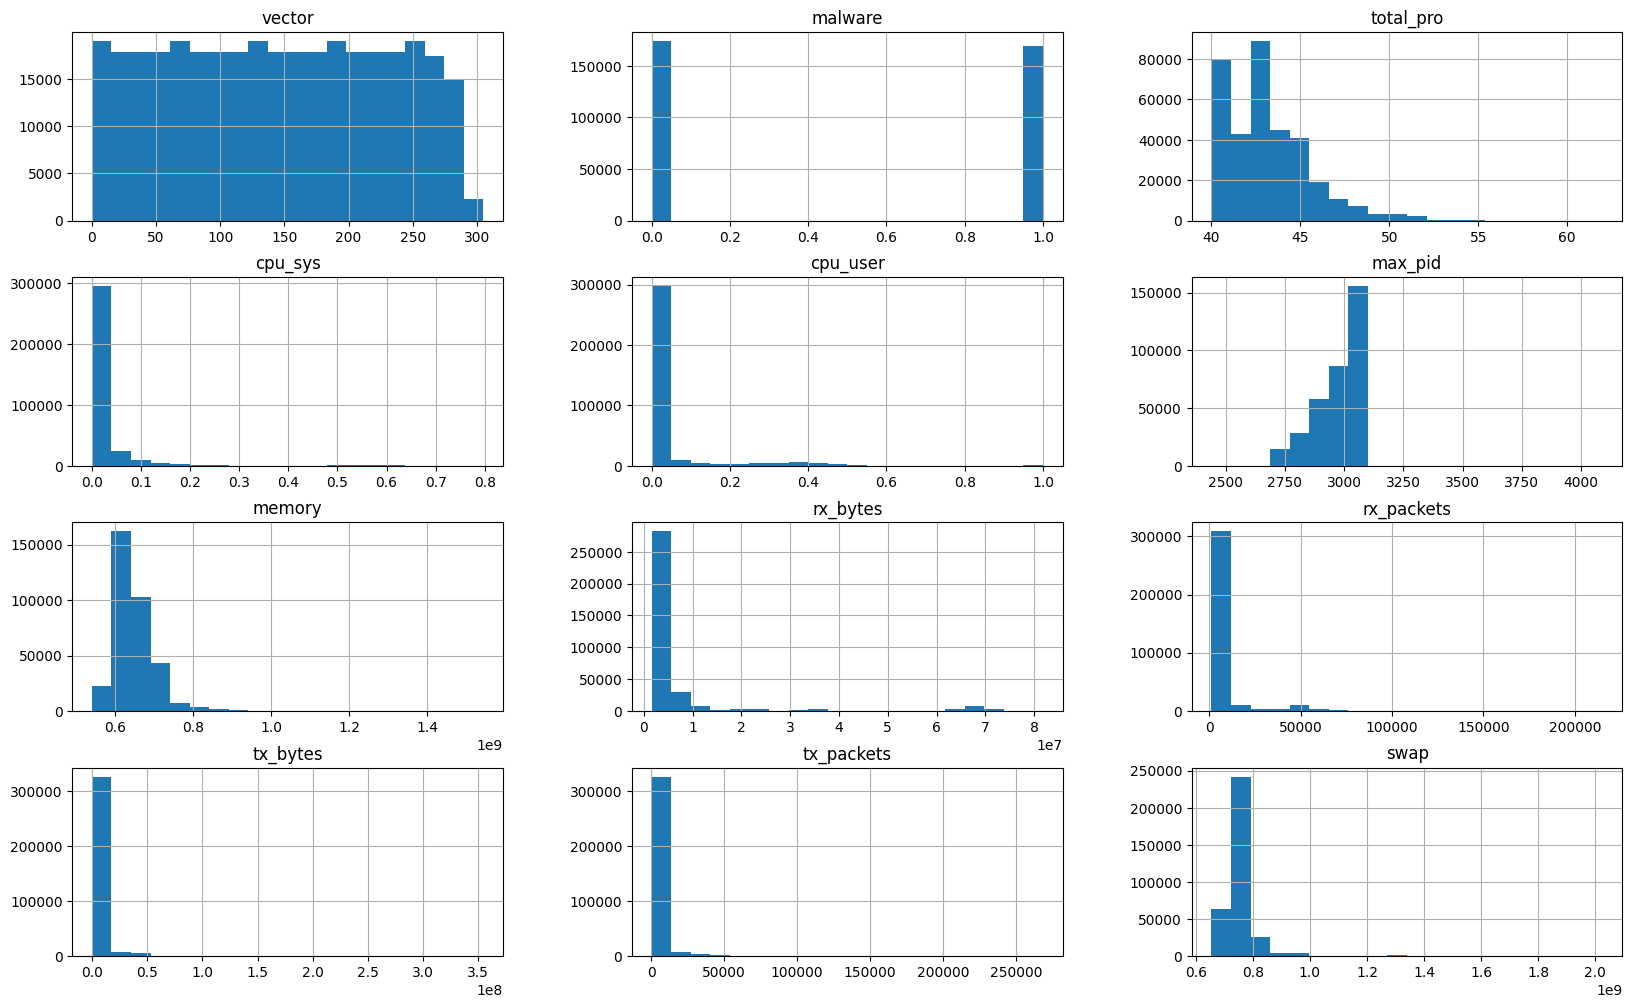

In [6]:
system_logs_subset.hist(bins=20, figsize=(20,12))

One thing of note which will need to be corrected is the malware column is being evaluated as continous where it is categoric
As is sample_id
Now I want to see the relationship between cpu measures to see if any patterns occur

<Axes: xlabel='cpu_sys', ylabel='cpu_user'>

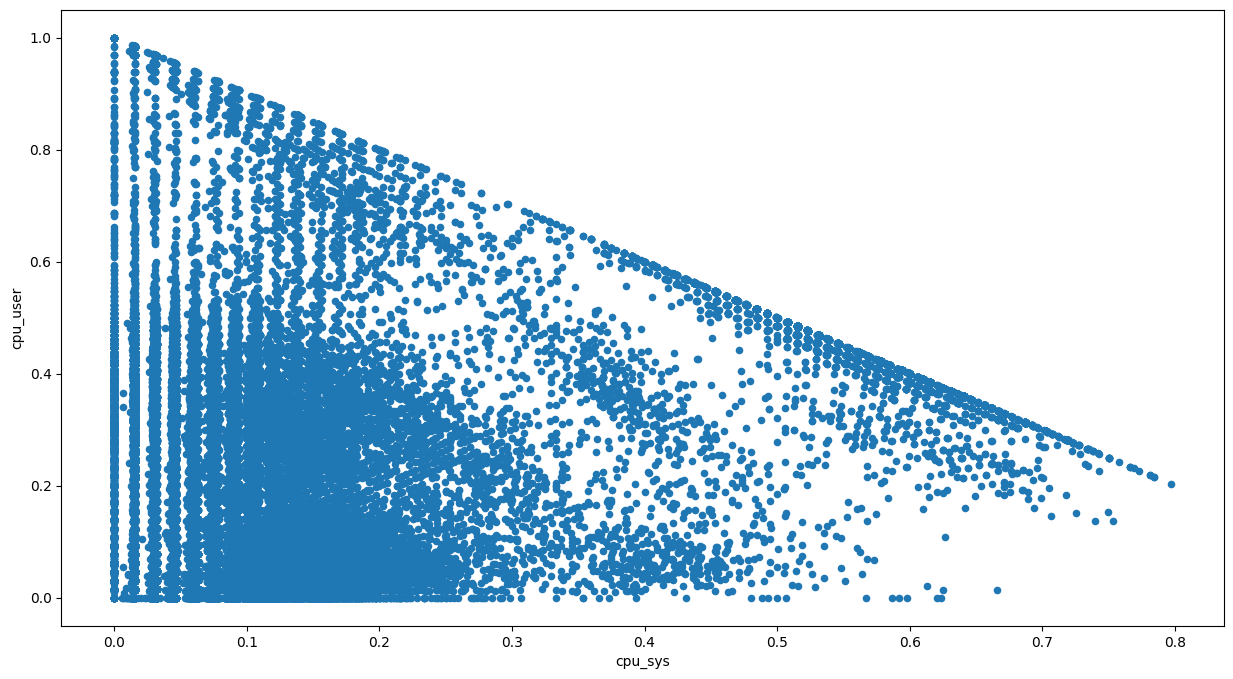

In [7]:
system_logs_subset[['cpu_sys','cpu_user']].plot(kind='scatter',x='cpu_sys',y='cpu_user',figsize=(15,8))

Some things to note is that cpu_sys never goes over 80% usage, not sure why system never goes over 80%, it could be that the system is designed with a cap in mind. whilst user does, it may be valuable to keep this data as there may be a relationship between a program being malware and the difference in system cpu usage and user as system is pertaining to low level activity.

In [8]:
system_logs_subset_high_sys = system_logs_subset[system_logs_subset['cpu_sys']>0.55]
system_logs_subset_high_sys.count()

vector        2551
malware       2551
total_pro     2551
cpu_sys       2551
cpu_user      2551
max_pid       2551
memory        2551
rx_bytes      2551
rx_packets    2551
tx_bytes      2551
tx_packets    2551
swap          2551
dtype: int64

2551 shows that most entries were before implying nearly all activity, that is 99.3%, doesn't need very much cpu usage in low level, this could be indicate a significant outlier group, which could indicate malware activity. I want to check where the population of malware activity lies on this graph.

<Axes: xlabel='cpu_sys', ylabel='cpu_user'>

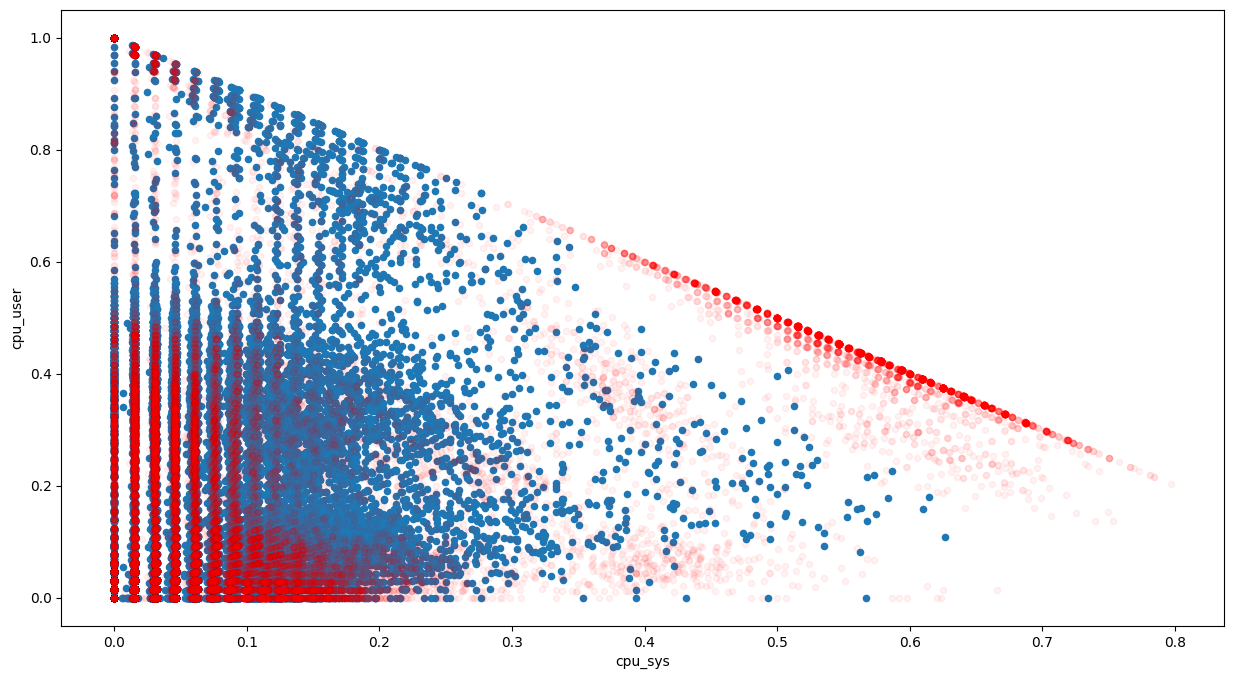

In [9]:
system_logs_subset_no_malware = system_logs_subset[system_logs_subset['malware']==0]
system_logs_subset_only_malware = system_logs_subset[system_logs_subset['malware']==1]
composite_part_plot = system_logs_subset_no_malware[['cpu_sys','cpu_user']].plot(kind='scatter',x='cpu_sys',y='cpu_user',figsize=(15,8))
system_logs_subset_only_malware[['cpu_sys','cpu_user']].plot(ax=composite_part_plot,color='red',kind='scatter',x='cpu_sys',y='cpu_user',figsize=(15,8),alpha=0.05)

The highest densities of malware are in extremes (red) which reflect the possibility of using anomoly detection in these features to accurately assess if a program is malware at these extremes, however other features should be used as some malware are in groups with non malware.

An interesting note is just how much overlap there is in malware in extreme sides of the axes, it could be possible that these are sub process of a larger program or these malware trying to achieve similar objectives.

vector        2536
malware       2536
total_pro     2536
cpu_sys       2536
cpu_user      2536
max_pid       2536
memory        2536
rx_bytes      2536
rx_packets    2536
tx_bytes      2536
tx_packets    2536
swap          2536
dtype: int64

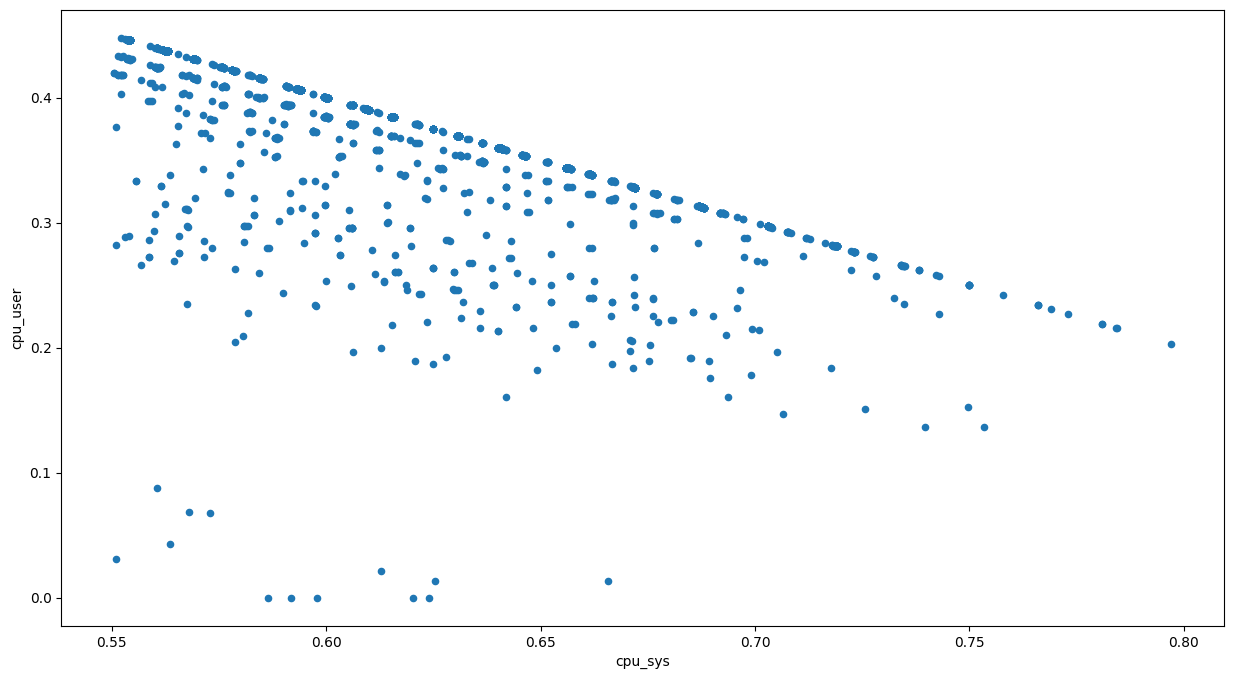

In [10]:
system_logs_subset_only_malware_high_sys_usage = system_logs_subset_high_sys[system_logs_subset_high_sys['malware']==1]
system_logs_subset_only_malware_high_sys_usage[['cpu_sys','cpu_user']].plot(kind='scatter',x='cpu_sys',y='cpu_user',figsize=(15,8))
system_logs_subset_only_malware_high_sys_usage.count()

In [11]:
system_logs_subset_high_sys.count()

vector        2551
malware       2551
total_pro     2551
cpu_sys       2551
cpu_user      2551
max_pid       2551
memory        2551
rx_bytes      2551
rx_packets    2551
tx_bytes      2551
tx_packets    2551
swap          2551
dtype: int64

2536/2551 of high system cpu usage (>55%) is malware, showing this is an effective metric to detect malware. And being a relatively small group 2551/343454 shows a very small group at an extreme deviation making them outliers. Machine learning could incoperate this metric into it's caculation.

<Axes: >

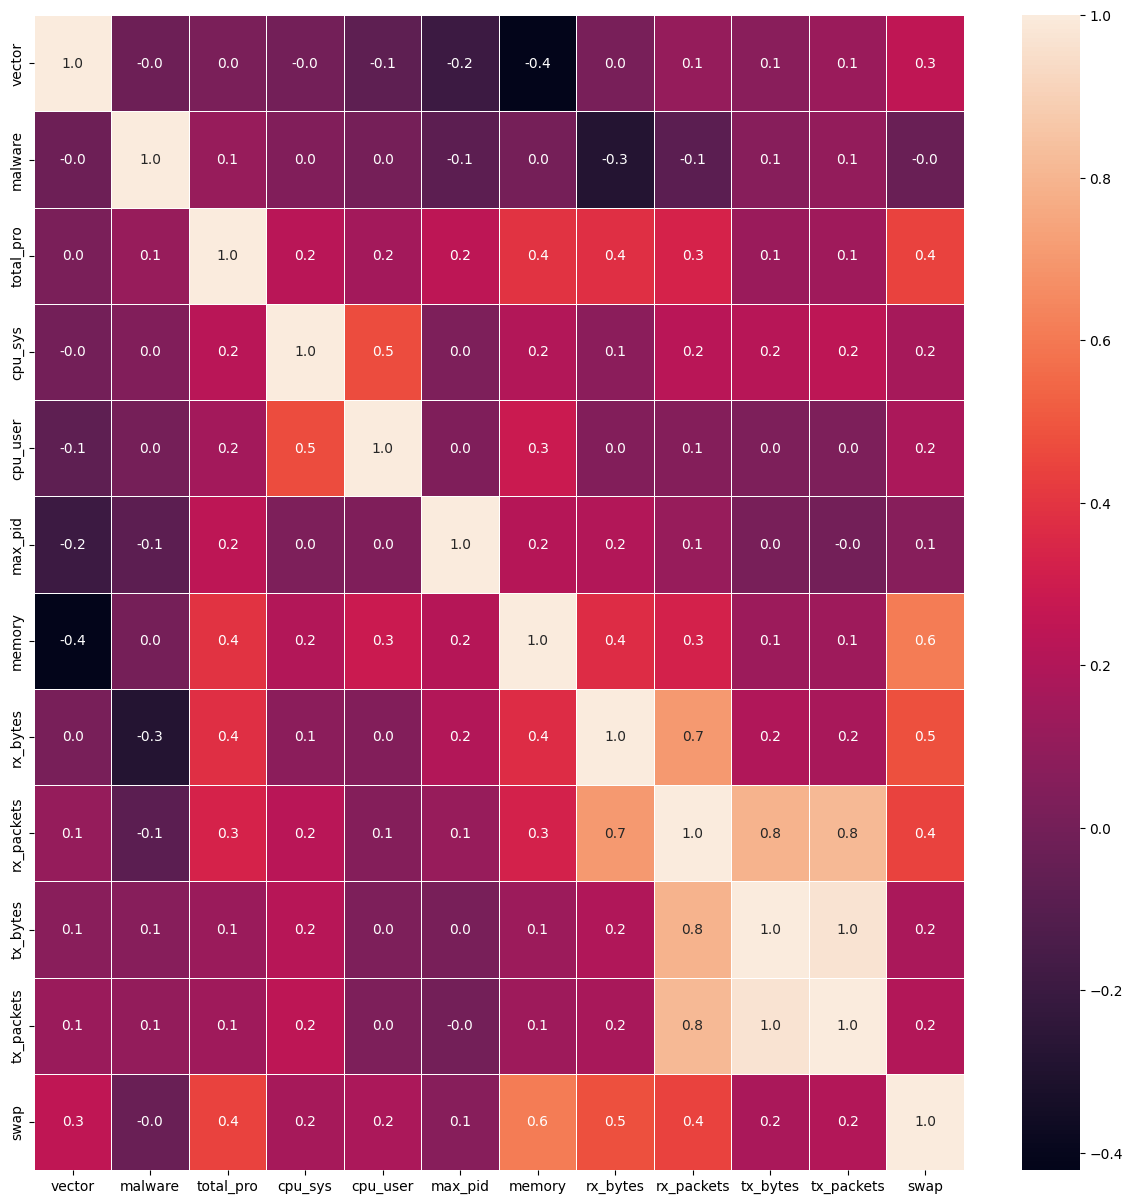

In [12]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(system_logs_subset.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [13]:
from sklearn.model_selection import train_test_split

droplist = ['total_pro.1', 'sample_id', 'test_set', 'malware','rx_bytes', 'rx_packets', 'tx_bytes', 'tx_packets']
x_1 = system_logs_gross_data.drop(droplist, axis = 1)
y_1 = system_logs_gross_data.malware
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(x_1, y_1, test_size=0.3, random_state=42)

import time

Random Forest:

Accuracy is:  92.06886846472626
Random Forest F1 Score: 91.9074686577806
Random Forest: execution time:  52.29576277732849 secs


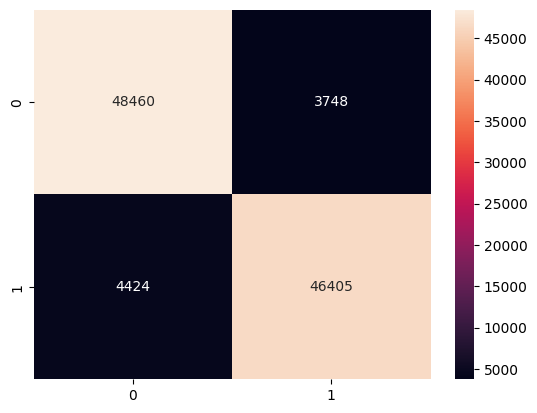

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

start_time = time.time()

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)
clr_rf = clf_rf.fit(x_train,y_train)

y_pred = clf_rf.predict(x_test)

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('Accuracy is: ',ac*100)
print("Random Forest F1 Score:", f1*100)

end_time = time.time()

cm = confusion_matrix(y_test,clf_rf.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")

print("Random Forest: execution time: ", end_time - start_time,"secs")

Next Model: Naive-Bayes

Naive Bayes Accuracy: 52.810155575181724
Naive Bayes F1 Score: 65.95528668753194
Naive-Bayes: execution time:  0.15769243240356445 secs


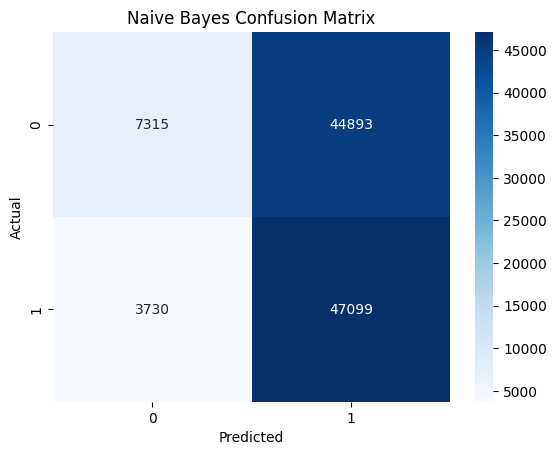

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

start_time = time.time()

nb_model = GaussianNB()
nb_model.fit(x_train, y_train)

# Predictions
y_pred = nb_model.predict(x_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output results
print("Naive Bayes Accuracy:", acc*100)
print("Naive Bayes F1 Score:", f1*100)

end_time = time.time()
print("Naive-Bayes: execution time: ", end_time - start_time,"secs")

# Confusion Matrix Heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Next Model: Guassian Mixture Model (GMM)

GMM Accuracy: 52.45009074410163
GMM F1 Score: 62.26993392579357
GMM: execution time:  3.0214529037475586 secs


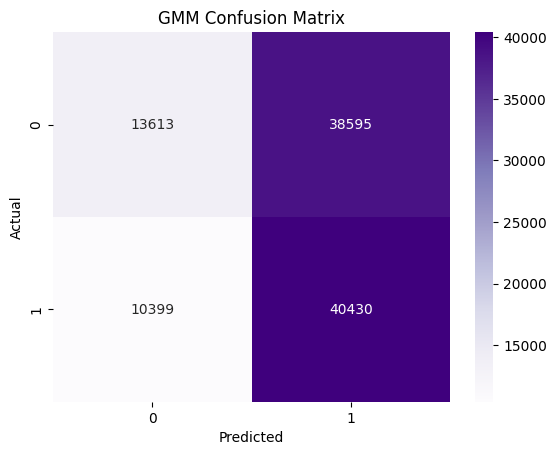

In [16]:
from sklearn.mixture import GaussianMixture
from scipy.stats import mode

start_time = time.time()

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(x_train)

# Predict cluster assignments - automatic - too complex to do manually 
train_clusters = gmm.predict(x_train)
test_clusters = gmm.predict(x_test)

# Map GMM clusters to actual labels based on majority vote
cluster_to_label = {}
for cluster_id in np.unique(train_clusters):
    label = mode(y_train[train_clusters == cluster_id], keepdims=True).mode[0]
    cluster_to_label[cluster_id] = label

# Map test cluster predictions to class labels
y_pred = np.vectorize(cluster_to_label.get)(test_clusters)

# Evaluate performance
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print("GMM Accuracy:", acc*100)
print("GMM F1 Score:", f1*100)

end_time = time.time()
print("GMM: execution time: ", end_time - start_time,"secs")

cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title('GMM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

GMM performs terribly with unormalised swap memory included - swap memory is removed to see if F1 score is improved

GMM Accuracy: 0.5066917709172433
GMM F1 Score: 0.0
GMM: execution time:  5.324607849121094 secs


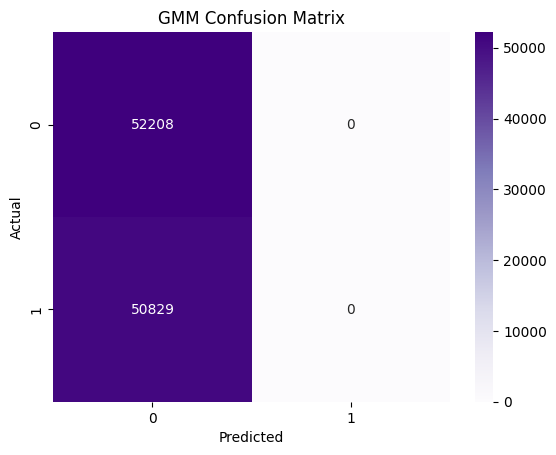

In [17]:
droplist = ['total_pro.1', 'sample_id', 'test_set', 'malware', 'swap', 'memory']
x_1 = system_logs_gross_data.drop(droplist, axis = 1)
y_1 = system_logs_gross_data.malware
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(x_1, y_1, test_size=0.3, random_state=42)


start_time = time.time()

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(x_train)

# Predict cluster assignments
train_clusters = gmm.predict(x_train)
test_clusters = gmm.predict(x_test)

# Map GMM clusters to actual labels based on majority vote
cluster_to_label = {}
for cluster_id in np.unique(train_clusters):
    label = mode(y_train[train_clusters == cluster_id], keepdims=True).mode[0]
    cluster_to_label[cluster_id] = label

# Map test cluster predictions to class labels
y_pred = np.vectorize(cluster_to_label.get)(test_clusters)

# Evaluate performance
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print metrics
print("GMM Accuracy:", acc)
print("GMM F1 Score:", f1)

end_time = time.time()
print("GMM: execution time: ", end_time - start_time,"secs")

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title('GMM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Maybe normalising 'swap' will allow GMM to use the feature still:

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Fit on 'swap' column in training set, transform both train and test
GMM_normalising = system_logs_gross_data
GMM_normalising['swap'] = scaler.fit_transform(GMM_normalising[['swap']])
GMM_normalising['memory'] = scaler.fit_transform(GMM_normalising[['memory']])
GMM_normalising.memory

0         0.109953
1         0.113141
2         0.110646
3         0.111372
4         0.100421
            ...   
343450    0.057080
343451    0.055775
343452    0.055775
343453    0.053676
343454    0.111995
Name: memory, Length: 343455, dtype: float64

Now that swap values are normalised we can try again with swap included:

GMM Accuracy: 0.5066917709172433
GMM F1 Score: 0.0
GMM: execution time:  5.3033127784729 secs


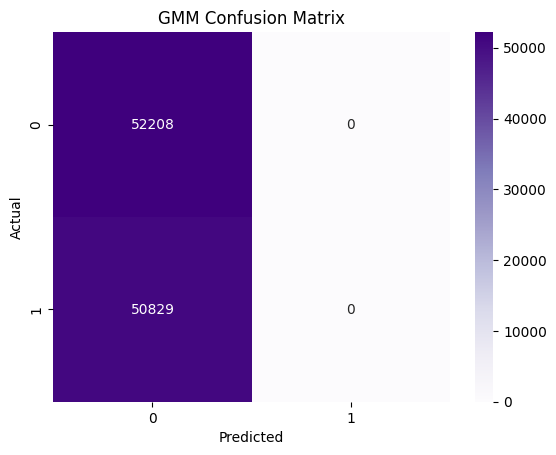

In [19]:
x_1 = GMM_normalising.drop(droplist, axis = 1)
y_1 = GMM_normalising.malware
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(x_1, y_1, test_size=0.3, random_state=42)


start_time = time.time()

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(x_train)

# Predict cluster assignments
train_clusters = gmm.predict(x_train)
test_clusters = gmm.predict(x_test)

# Map GMM clusters to actual labels based on majority vote
cluster_to_label = {}
for cluster_id in np.unique(train_clusters):
    label = mode(y_train[train_clusters == cluster_id], keepdims=True).mode[0]
    cluster_to_label[cluster_id] = label

# Map test cluster predictions to class labels
y_pred = np.vectorize(cluster_to_label.get)(test_clusters)

# Evaluate performance
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print metrics
print("GMM Accuracy:", acc)
print("GMM F1 Score:", f1)

end_time = time.time()
print("GMM: execution time: ", end_time - start_time,"secs")

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title('GMM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()